In [1]:
import pandas as pd
import psycopg2

## What are my top played artists?

In [2]:
conn = psycopg2.connect("host=localhost dbname=spotify user=postgres password=###")
cur = conn.cursor()

In [3]:
cur.execute("""
    SELECT artistName, COUNT(*)
    FROM songplay
    WHERE playedat BETWEEN '2020-09-01' AND '2020-09-30'
    GROUP BY artistName
    ORDER BY 2 DESC
""")

In [4]:
results = cur.fetchall()

In [5]:
cur.close()

In [6]:
df = pd.DataFrame(results, columns=['artistName','playCount'])
df.head(5)

,artistName,playCount
0,Sinead Harnett,76
1,Bobby Bazini,45
2,Fred Everything,41
3,Icarus,13
4,Lane 8,12


## How does my consumption change related to the day of the week?

In [7]:
cur = conn.cursor()

In [8]:
start_date = '2020-08-01'
end_date = '2021-03-31'

cur.execute(f"""
    SELECT DATE(playedAt), COUNT(*)
    FROM songplay
    WHERE playedAt BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY DATE(playedAT)
""")

In [9]:
results = cur.fetchall()

In [10]:
df = pd.DataFrame(results, columns=['date','playCount'])
df.head(5)

,date,playCount
0,2020-12-23,3
1,2021-01-21,9
2,2021-02-10,11
3,2020-08-03,39
4,2020-08-24,106


In [11]:
df['date'] = pd.to_datetime(df['date'])
idx = pd.date_range(start_date, end_date)
df = df.set_index('date').reindex(idx,fill_value=0).rename_axis('date').reset_index()
len(df)

243

In [12]:
df['dayOfWeek'] = df['date'].map(lambda x: x.dayofweek)
df['dayOfWeekName'] = df['date'].map(lambda x: x.strftime("%A"))

In [13]:
df.head(5)

,date,playCount,dayOfWeek,dayOfWeekName
0,2020-08-01,40,5,Saturday
1,2020-08-02,39,6,Sunday
2,2020-08-03,39,0,Monday
3,2020-08-04,49,1,Tuesday
4,2020-08-05,42,2,Wednesday


In [14]:
df_agg = df.filter(['dayOfWeek','dayOfWeekName','playCount']) \
    .groupby(['dayOfWeek', 'dayOfWeekName']).mean('playCount').reset_index()

<AxesSubplot:xlabel='dayOfWeekName'>

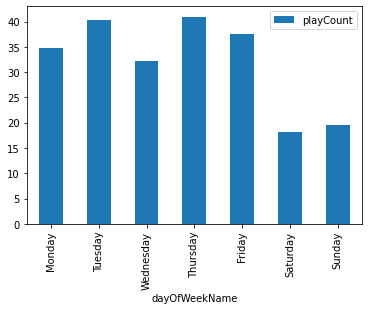

In [15]:
df_agg.plot(kind = 'bar', x='dayOfWeekName', y='playCount')

## What are my top played tracks and how many times do I played the same track on average?

In [16]:
cur = conn.cursor()
cur.execute(f"""
    SELECT songName, artistName, COUNT(*)
    FROM songplay
    WHERE playedAt BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY songName, artistName
""")
results = cur.fetchall()

In [17]:
df2 = pd.DataFrame(results, columns = ["songName", "artistName", "playCount"])
df2.sort_values('playCount', ascending = False).head(5)

,songName,artistName,playCount
576,Pressure (with SG Lewis),James Vickery,55
2463,Frozen,Sabrina Claudio,51
3254,Plus tôt,Alexandra Streliski,47
2155,Familiar Grounds,Lihua Zhao,42
2351,River Flows In You,Yiruma,34


In [18]:
print(f"Average track play count: {df2.playCount.mean()}")

Average track play count: 2.0715050883770756


## How does seasonality affect my music consumption?

In [19]:
df['period'] = df['date'].map(lambda x: x.strftime('%Y-%m'))

In [22]:
df_agg2 = df.filter(['period','playCount']) \
    .groupby(['period']).sum('playCount').reset_index()

<AxesSubplot:xlabel='period'>

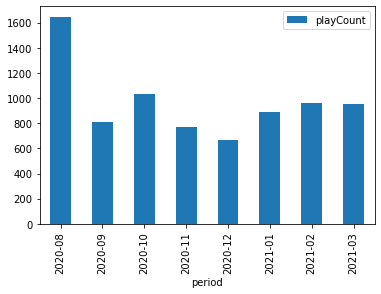

In [24]:
df_agg2.plot(kind = 'bar', x='period', y='playCount')